In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries(path):
    f = open(path)
    queries = []
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                tmp.append(q)
        queries.append(tmp)
    f.close()
    return queries

def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
        queries.append(tmp)
    f.close()
    return queries

In [4]:
path = 'data/requests.uniq.train'
train = read_queries(path)
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test = read_queries(path)
test_lem = read_queries_with_lemmatization(path)
train[:5], train_lem[:5], test[:5], test_lem[:5], len(train), len(test)

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 [['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикая', 'вишня'],
  ['тася', 'кривун', 'танцы', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 51353,
 21174)

In [5]:
count_words = Counter()

for d in [train]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.17574006, 0.24519813, 0.29055625, 0.32405664, 0.35185578,
        0.37601319, 0.39457541, 0.41182944, 0.42762059, 0.4410561 ]))

In [86]:
count_words = Counter()

for d in [train_lem]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

### Посмотрим, что будет если учить по оригиналу и затем сверять с точностью до леммы

In [7]:
emb = KeyedVectors.load_word2vec_format("wiki.ru.vec")
emb_1 = KeyedVectors.load_word2vec_format("cc.ru.300.vec")
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
def calculate_n_tokens(emb):
    n_tokens = 0
    for word in count_words.keys():
        if word in emb.vocab and count_words[word] >= 3:
            n_tokens += 1
    return n_tokens + 1

In [10]:
def transform_to_features(emb, emb_size, ind_to_word, batch_x):
    to_emb = np.zeros((len(batch_x), len(batch_x[0])+1, emb_size))
    for i in range(len(batch_x)):
        to_emb[i][0] = np.ones(emb_size)
        for j in range(len(batch_x[i])):
            if batch_x[i][j] != pad_id:
                to_emb[i][j+1] = emb[ind_to_word[batch_x[i][j]]]
    return to_emb

In [11]:
class Net(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens) 
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits = self.logits(lstm_out[0])
        
        return logits

In [70]:
pad = '#PAD#'
pad_id = 0

def construct_vocab(emb, count_words):
    word_to_ind = dict()
    word_to_ind['#PAD#'] = 0
    ind_to_word = ['#PAD#', ]
    
    count = 1
    for word in count_words.keys():
        if count_words[word] >= 3 and word in emb.vocab:
            ind_to_word.append(word)
            word_to_ind[word] = count
            count += 1
    return ind_to_word, word_to_ind


def as_matrix(sequences, word_to_ind, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq[:max_len]):
            if word in word_to_ind.keys():
                matrix[i][j] = word_to_ind[word]
            else:
                matrix[i][j] = pad_id
        for j in range(max_len, len(seq)):
            matrix[i][j] = pad_id
    
    return matrix

In [54]:
def construct_lemmatization_vocab(emb, ind_to_word, word_to_ind):
    mystem = Mystem()
    ind_to_lem_ind = [0, ]
    word_lems = dict()
    count = 1
    
    for word in ind_to_word[1:]:
        word_lem = mystem.lemmatize(word)[0]
        if word_lem not in word_lems.keys():
            word_lems[word_lem] = count
            count += 1
        ind_to_lem_ind.append(word_lems[word_lem])
        
    return ind_to_lem_ind
        
    
def convert_to_lem(data, ind_to_lem_ind):
    data_lem = np.zeros_like(data)
    for i, x in enumerate(data):
        for j, y in enumerate(x):
            data_lem[i][j] = ind_to_lem_ind[y]
    return data_lem

def compute_accr(network, batch_x, ind_to_lem_ind, lem):
    batch_x = np.array(batch_x)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    
    if lem == 1:
        batch_x_next = convert_to_lem(batch_x_next, ind_to_lem_ind)
        answers = convert_to_lem(answers, ind_to_lem_ind)
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr[0]
    accr = accr.sum(axis=0)
    to_divide = np.array([batch_x_next != pad_id])[0].sum(axis=0)
    
    return accr, to_divide

In [55]:
def get_batch(data, left, right, batch_size, word_to_ind, max_len=None):
    slice_x = np.arange(left, right, 1)
    batch_x = []
    for x in slice_x:
        batch_x.append(data[x])
    return as_matrix(batch_x, word_to_ind, max_len)

def try_lengthes(data, ind_to_lem_ind, lem=0):
    accr = np.zeros(np.max(list(map(len, data))))
    to_div = np.zeros(np.max(list(map(len, data))))
    
    for _ in tqdm_notebook(range(0, len(data)-batch_size, batch_size)):
        accr_t, div_t = compute_accr(network, get_batch(data, _, _+batch_size, batch_size, word_to_ind), 
                                     ind_to_lem_ind, lem)
        accr[:len(accr_t)] += accr_t
        to_div[:len(div_t)] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum() / to_div.sum()

In [51]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

In [45]:
ind_to_word, word_to_ind = construct_vocab(emb, count_words)
ind_to_lem_ind = construct_lemmatization_vocab(emb, ind_to_word, word_to_ind)
network = Net(emb, ind_to_word)
network.load_state_dict(torch.load('emb_no_lemmatization.pwf'))

In [46]:
len(ind_to_lem_ind), len(np.unique(ind_to_lem_ind)), len(ind_to_word)

(11111, 7601, 11111)

In [47]:
batch_size = 64

In [62]:
from tqdm import tqdm_notebook

accrs_emb = []

for i, data in enumerate([train, test]):
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=0)
    pad_data = approximate_pad(data)
    accrs_emb.append(accr * (1.0 - pad_data))
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=1)
    accrs_emb.append(accr * (1.0 - pad_data))

### emb_1

In [63]:
ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
ind_to_lem_ind = construct_lemmatization_vocab(emb_1, ind_to_word, word_to_ind)
network = Net(emb_1, ind_to_word)
network.load_state_dict(torch.load('emb_1_no_lemmatization.pwf'))

accrs_emb_1 = []

for i, data in enumerate([train, test]):
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=0)
    pad_data = approximate_pad(data)
    accrs_emb_1.append(accr * (1.0 - pad_data))
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=1)
    accrs_emb_1.append(accr * (1.0 - pad_data))

### emb_2

In [67]:
ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
ind_to_lem_ind = construct_lemmatization_vocab(emb_2, ind_to_word, word_to_ind)
network = Net(emb_2, ind_to_word)
network.load_state_dict(torch.load('emb_2_no_lemmatization.pwf'))

accrs_emb_2 = []

for i, data in enumerate([train, test]):
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=0)
    pad_data = approximate_pad(data)
    accrs_emb_2.append(accr * (1.0 - pad_data))
    accr, all_accr = try_lengthes(data, ind_to_lem_ind, lem=1)
    accrs_emb_2.append(accr * (1.0 - pad_data))

## Графики

In [71]:
train_st = dict()
test_st = dict()
train_pad = dict()
test_pad = dict()

for lm in ['', '_no']:
    if lm == '_no':
        count_words = Counter()

        for d in [train]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    else:
        count_words = Counter()

        for d in [train_lem]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    
    
    for num in ['', '_1', '_2']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        f = open(path, 'r')
        count = 0
        i = -1
        tmp = []
        for line in f:
            if count==0:
                count = int(line.split()[0])
                i += 1
                if i == 5:
                    train_st[path] = tmp
                tmp = []
            else:
                count -= 1
                y = float(line.split()[0])
                tmp.append(y)
        test_st[path] = tmp
        
        if num == '':
            ind_to_word, word_to_ind = construct_vocab(emb, count_words)
        if num == '_1':
            ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
        if num == '_2':
            ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
        
        if lm == '_no':
            train_pad[path] = approximate_pad(train)
            test_pad[path] = approximate_pad(test)
        else:
            train_pad[path] = approximate_pad(train_lem)
            test_pad[path] = approximate_pad(test_lem)
                
        f.close()

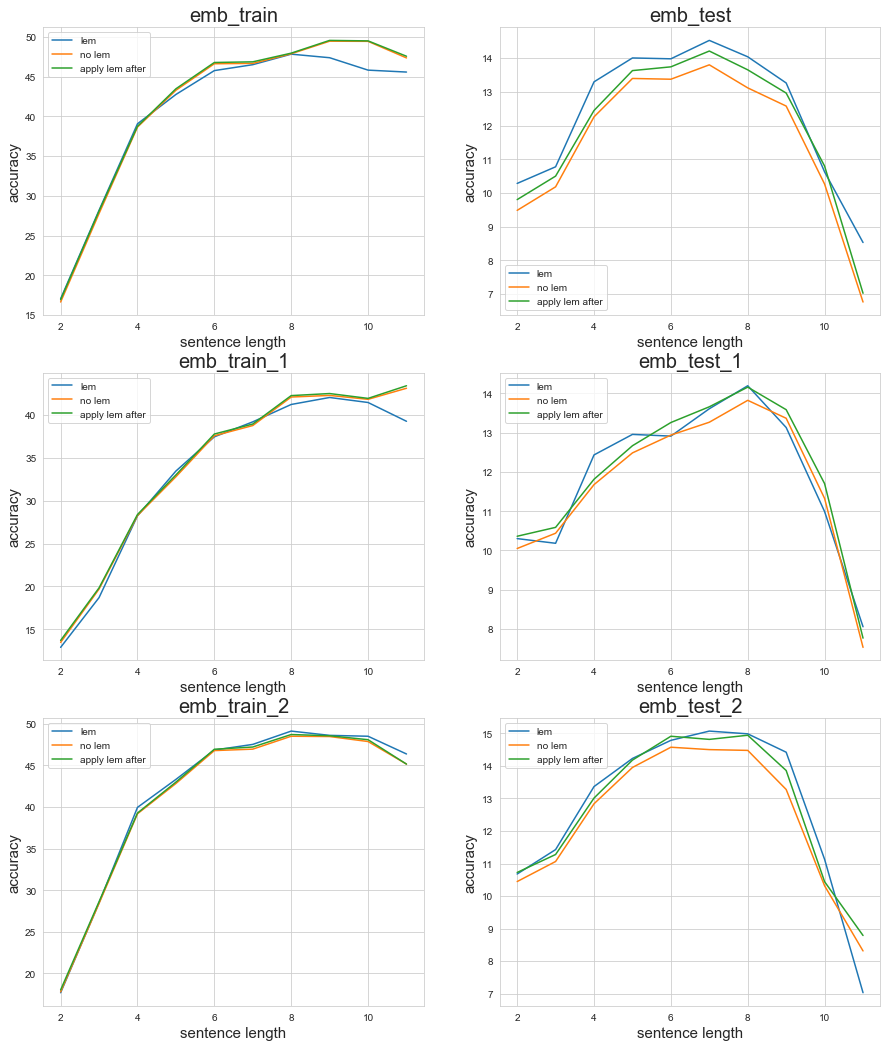

In [76]:
plt.figure(figsize=(15, 18))

grid = np.arange(0, 10) + 2
bound = len(grid)
nums = ['', '_1', '_2']

for i, accrs in enumerate([accrs_emb, accrs_emb_1, accrs_emb_2]):
    plt.subplot(3, 2, i*2+1)
    
    path = 'emb' + nums[i] + '_lemmatization.txt'
    plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), label='lem')
    plt.plot(grid, 100*np.array(accrs[0])[:bound], label='no lem')
    plt.plot(grid, 100*np.array(accrs[1])[:bound], label='apply lem after')
        
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.title('emb_train'+nums[i], fontsize=20)
    
    plt.subplot(3, 2, i*2+2)
    
    
    plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), label='lem')
    plt.plot(grid, 100*np.array(accrs[2])[:bound], label='no lem')
    plt.plot(grid, 100*np.array(accrs[3])[:bound], label='apply lem after')
        
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.title('emb_test'+nums[i], fontsize=20)

plt.show()

In [85]:
bound = 8

for i, accrs in enumerate([accrs_emb, accrs_emb_1, accrs_emb_2]):
    path = 'emb' + nums[i] + '_lemmatization.txt'
    lem = 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path])
    no_lem = 100*np.array(accrs[0])[:bound]
    apply_lem_after = 100*np.array(accrs[1])[:bound]
    print('between lem and after lem | after lem and no lem')
    print('train')
    print(np.mean(lem - apply_lem_after), np.mean(apply_lem_after - no_lem))
    
    lem = 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path])
    no_lem = 100*np.array(accrs[2])[:bound]
    apply_lem_after = 100*np.array(accrs[3])[:bound]
    print('test')
    print(np.mean(lem - apply_lem_after), np.mean(apply_lem_after - no_lem))
    print()

between lem and after lem | after lem and no lem
train
-0.48426057729284633 0.1772563057354608
test
0.40259969926955796 0.3445921712126607

between lem and after lem | after lem and no lem
train
-0.4015247245560938 0.18370945802224004
test
-0.04653952299890052 0.2561611480929127

between lem and after lem | after lem and no lem
train
0.1509185896932208 0.17633751564899836
test
0.15520131313033847 0.3247851358163454



### Пробуем изменить метрику успеха | точность, топ-n

In [180]:
def try_lengthes(data, n=1):
    accr = np.zeros((np.max(list(map(len, data))), n))
    to_div = np.zeros((np.max(list(map(len, data))), n))
    
    for _ in tqdm_notebook(range(0, len(data)-batch_size, batch_size)):
        accr_t, div_t = compute_accr(network, get_batch(data, _, _+batch_size, batch_size, word_to_ind), n)
        accr[:len(accr_t), :] += accr_t
        to_div[:len(div_t), :] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum(axis=0) / to_div.sum(axis=0)

def compute_accr(network, batch_x, n):
    batch_x = np.array(batch_x)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = np.flip(torch.argsort(logits_for_next, dim=-1).numpy()[:, :, -n:], axis=-1)
    tmp = batch_x_next.reshape(batch_x_next.shape[0], batch_x_next.shape[1], 1)
    answers = np.cumsum(np.array([answers == tmp]), axis=-1)[0]
    
    accr = answers * np.array([tmp != pad_id])[0]
    accr = accr.sum(axis=0)
    to_divide = np.array([tmp != pad_id])[0].sum(axis=0)
    
    return accr, to_divide

In [93]:
ind_to_word, word_to_ind = construct_vocab(emb, count_words)
network = Net(emb, ind_to_word)
network.load_state_dict(torch.load('emb_lemmatization.pwf'))

In [187]:
accrs_emb = []
possible_n = [1, 2, 4, 10]

for i, data in enumerate([test_lem, train_lem]):
    pad_data = approximate_pad(data)
    accr, all_accr = try_lengthes(data, n)
    accr = accr * (1.0 - pad_data)
    for j in range(len(possible_n)):
        accrs_emb.append(accr[:, possible_n[j]-1])

In [190]:
ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
network = Net(emb_1, ind_to_word)
network.load_state_dict(torch.load('emb_1_lemmatization.pwf'))

accrs_emb_1 = []

for i, data in enumerate([test_lem, train_lem]):
    pad_data = approximate_pad(data)
    accr, all_accr = try_lengthes(data, n)
    accr = accr * (1.0 - pad_data)
    for j in range(len(possible_n)):
        accrs_emb_1.append(accr[:, possible_n[j]-1])

In [191]:
ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = Net(emb_2, ind_to_word)
network.load_state_dict(torch.load('emb_2_lemmatization.pwf'))

accrs_emb_2 = []

for i, data in enumerate([test_lem, train_lem]):
    pad_data = approximate_pad(data)
    accr, all_accr = try_lengthes(data, n)
    accr = accr * (1.0 - pad_data)
    for j in range(len(possible_n)):
        accrs_emb_2.append(accr[:, possible_n[j]-1])

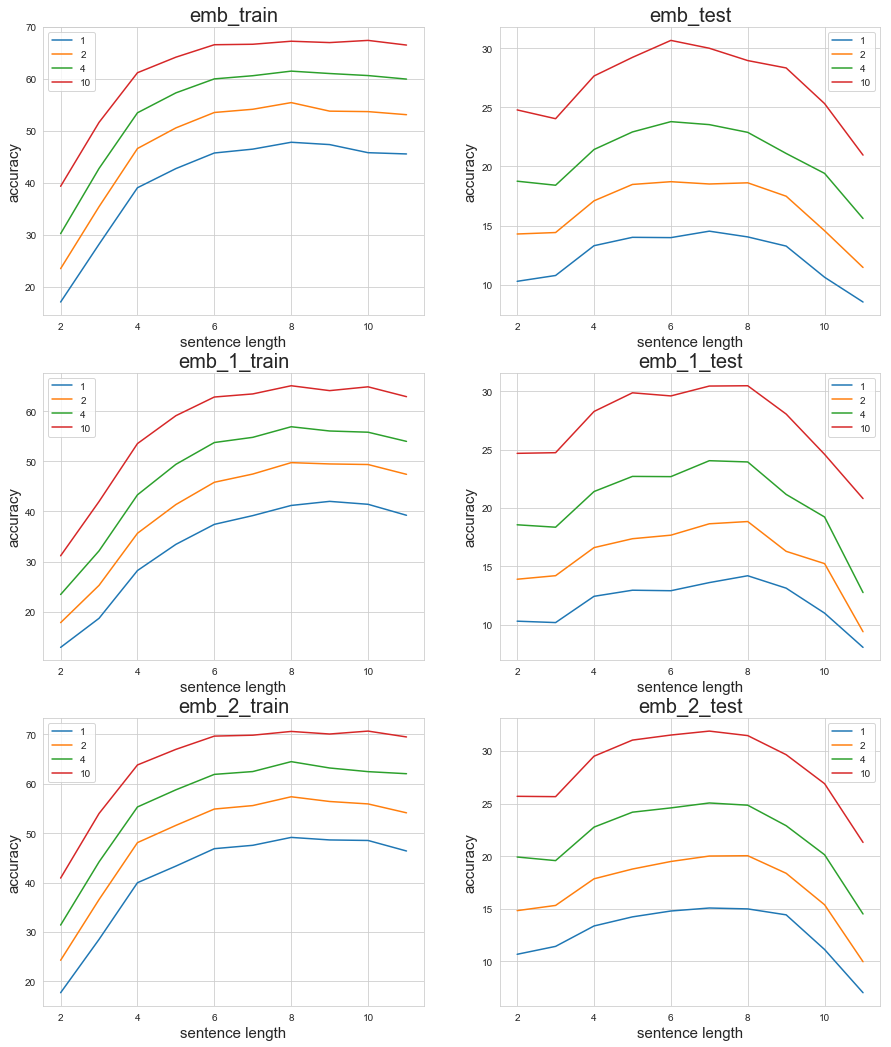

In [192]:
plt.figure(figsize=(15, 18))

grid = np.arange(0, 10) + 2
bound = len(grid)

for j, accrs in enumerate([accrs_emb, accrs_emb_1, accrs_emb_2]):
    plt.subplot(3, 2, 1+2*j)   
    for i in range(4):
        plt.plot(grid, 100*np.array(accrs[4+i])[:bound], label=str(possible_n[i]))
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    emb = 'emb'
    if j > 0:
        emb += '_' + str(j)
    plt.title(emb + '_train', fontsize=20)
    
    plt.subplot(3, 2, 2+2*j)
    for i in range(4):
        plt.plot(grid, 100*np.array(accrs[i])[:bound], label=str(possible_n[i]))
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.title(emb + '_test', fontsize=20)

plt.show()

### Посмотрим, как качество зависит от размера обучающей выборки